# Kernel PCA

## Create toy data

In [111]:
import numpy as np

sigma = 0.1

num_of_samples = 30
shape = [num_of_samples, 2]
X1 = np.random.normal([-0.5, -0.2], sigma, shape).T
X2 = np.random.normal([-0, 0.6], sigma, shape).T
X3 = np.random.normal([0.5, 0], sigma, shape).T

X = np.concatenate([X1, X2, X3], axis=1)
N, p = X.shape

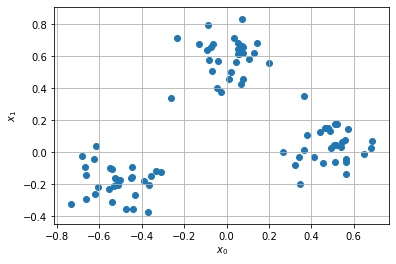

In [112]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.scatter(X[0], X[1])
ax.set_xlabel("$x_0$")
ax.set_ylabel("$x_1$")
ax.grid()

## Apply kernel PCA using RBF kernel

### RBF kernel

In [113]:
from numpy.linalg import norm

def rbf_kernel(x1, x2, sigma):
    return np.exp(-norm(x1 - x2)**2/(2*sigma**2))

In [114]:
x1 = np.array([1, 2])
x2 = np.array([4, 3])
rbf_kernel(x1, x2, sigma)

7.124576406741286e-218

In [115]:
import sklearn.gaussian_process

RBF = sklearn.gaussian_process.kernels.RBF(sigma)
RBF(x1.reshape(-1, 2), x2.reshape(-1, 2))

array([[7.12457641e-218]])

### Kernel matrix

In [134]:
# Performance can be improved by using vectorization, e.g. https://stats.stackexchange.com/a/15817
K_tilde = np.zeros([p, p])
for i in np.arange(p):
    for j in np.arange(p):
        K_tilde[i, j] = rbf_kernel(X[:,i], X[:,j], sigma)

K_tilde

array([[1.00000000e+00, 6.33475840e-01, 6.94662999e-01, ...,
        4.87220477e-12, 7.96042757e-11, 6.99928264e-21],
       [6.33475840e-01, 1.00000000e+00, 2.03067271e-01, ...,
        7.02674402e-14, 7.21007470e-13, 2.84256512e-23],
       [6.94662999e-01, 2.03067271e-01, 1.00000000e+00, ...,
        4.28653517e-10, 8.21599823e-09, 3.11635696e-18],
       ...,
       [4.87220477e-12, 7.02674402e-14, 4.28653517e-10, ...,
        1.00000000e+00, 6.11787551e-01, 5.39514475e-02],
       [7.96042757e-11, 7.21007470e-13, 8.21599823e-09, ...,
        6.11787551e-01, 1.00000000e+00, 1.10005325e-02],
       [6.99928264e-21, 2.84256512e-23, 3.11635696e-18, ...,
        5.39514475e-02, 1.10005325e-02, 1.00000000e+00]])

In [135]:
K_tilde_row_avg = np.mean(K_tilde, axis=0)[np.newaxis]
K_tilde_col_avg = np.mean(K_tilde, axis=1)[np.newaxis].T
K_tilde_avg = np.mean(K_tilde)
K = K_tilde - K_tilde_row_avg - K_tilde_col_avg + K_tilde_avg

### Rewrite as functions for later calculations

In [136]:
def center_K(K_tilde):
    K_tilde_row_avg = np.mean(K_tilde, axis=0)[np.newaxis]
    K_tilde_col_avg = np.mean(K_tilde, axis=1)[np.newaxis].T
    K_tilde_avg = np.mean(K_tilde)
    K = K_tilde - K_tilde_row_avg - K_tilde_col_avg + K_tilde_avg
    return K

In [162]:
def calculate_K(sample, reference):
    """Calculate Kernel matrix for a set of reference points and a sample. Reference is original data.
    Sample is either testing data or the original data (then training data sample == reference)."""
    p = reference.shape[1]
    q = sample.shape[1]
    K_tilde = np.zeros([p, q])
    for sample_index in np.arange(q):
        for reference_index in np.arange(p):
            K_tilde[reference_index, sample_index] = rbf_kernel(reference[:,reference_index], sample[:,sample_index], sigma)
    return center_K(K_tilde)

#### Test if functions produce the same results

In [163]:
np.array_equal(K, center_K(K_tilde))

True

In [164]:
np.array_equal(K, calculate_K(X, X))

True

### Eigenvalue decomposition

In [165]:
def sort_eigenvalues(lambdas, M):
    sort_perm = lambdas.argsort()[::-1]
    lambdas = lambdas[sort_perm]
    M = M[:,sort_perm]
    return lambdas, M

In [166]:
from numpy.linalg import eig

lambdas, A_tilde = eig(K)
lambdas, A_tilde = sort_eigenvalues(lambdas, A_tilde)
lambdas = np.abs(lambdas)
print(A_tilde)

[[ 1.12383525e-02  1.58552732e-01  4.05213850e-02 ... -6.29910911e-03
   1.66477533e-06  1.05409255e-01]
 [ 1.03605637e-02  1.45475994e-01  2.39721596e-02 ... -1.36663244e-03
   3.68452172e-07  1.05409255e-01]
 [ 6.84170631e-03  9.39399102e-02  8.46476230e-03 ...  7.91041504e-04
  -1.86816442e-06  1.05409255e-01]
 ...
 [ 3.57868538e-02 -2.13777963e-02 -1.62243786e-01 ... -5.14049015e-07
   3.36237119e-08  1.05409255e-01]
 [ 2.71172303e-02 -1.54136461e-02 -1.09299206e-01 ... -8.46614495e-07
   1.53309884e-06  1.05409255e-01]
 [ 1.14557405e-01 -7.89218724e-02 -2.01588626e-01 ... -2.36311983e-05
   4.25092887e-05  1.05409255e-01]]


In [167]:
A = A_tilde / np.sqrt(lambdas)
print(A)

[[ 3.35114217e-03  4.80672490e-02  1.72853927e-02 ... -2.53466982e+01
   1.40725194e-02  3.79513787e+06]
 [ 3.08939605e-03  4.41028718e-02  1.02259139e-02 ... -5.49913002e+00
   3.11456461e-03  3.79513787e+06]
 [ 2.04011492e-03  2.84790619e-02  3.61085241e-03 ...  3.18303587e+00
  -1.57917885e-02  3.79513787e+06]
 ...
 [ 1.06712114e-02 -6.48094705e-03 -6.92090747e-02 ... -2.06845841e-03
   2.84224741e-04  3.79513787e+06]
 [ 8.08603345e-03 -4.67284013e-03 -4.66242627e-02 ... -3.40665350e-03
   1.29594443e-02  3.79513787e+06]
 [ 3.41596467e-02 -2.39261554e-02 -8.59925835e-02 ... -9.50885023e-02
   3.59335447e-01  3.79513787e+06]]


## Project test points

In [238]:
test_points = np.array([[-0.6, 0.7], [0.5, 0.3], [-0.4, 0.4]]).T
print(test_points.shape)
K_test = calculate_K(test_points, X)
print(K_test.shape)

# One column in Kernel matrix corresponds to one test point
u_0_0 = 0
for i in np.arange(p):
    u_0_0 += A[i, 0] * K_test[i, 0]
print(u_0_0)

(2, 3)
(90, 3)
-0.04302848702672634


#### Trying to vectorize calculation (same as with linear PCA)

Calculating `u` for one test point and one PC:

In [246]:
u_0_0_vect = A[:,0].T @ K_test[:, 0]
np.isclose(u_0_0, u_0_0_vect)

True

Calculating `u` for all test point and one PC:

In [247]:
U_0 = A[:,0].T @ K_test
print(np.isclose(U_0[0], u_0_0))

True


Calculating `u` for one test point and set of PCs:

In [248]:
U = A[:,:8].T @ K_test
print(np.isclose(U[0, 0], u_0_0))

True


## Visualize PCs

In [295]:
nx, ny = (200, 200)

grid_x = np.linspace(*[-0.8, 0.8], num=nx)
grid_y = np.linspace(*[-0.6, 1], num=ny)

grid_points = []
for x in grid_x:
    for y in grid_y:
        grid_points.append([x, y])
grid_points = np.array(grid_points).T
print(grid_points.shape)

(2, 40000)


In [296]:
K_grid = calculate_K(grid_points, X)
print(K_grid.shape)
U_grid = A[:,:8].T @ K_grid
print(U_grid.shape)

(90, 40000)
(8, 40000)


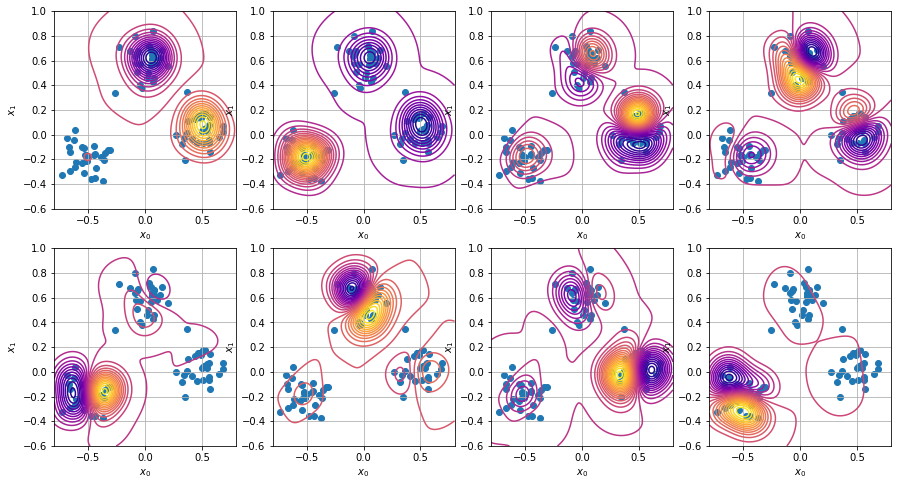

In [306]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(15, 8))
for i in np.arange(8):
    ax = axs.flat[i]
    ax.scatter(X[0], X[1])
    ax.set_xlabel("$x_0$")
    ax.set_ylabel("$x_1$")
    ax.grid()
    ax.contour(grid_x, grid_y, U_grid[i].reshape(nx, ny).T, levels=30, cmap="plasma")